<a href="https://colab.research.google.com/github/Rucamont/SkForecast---Farm/blob/main/SKForecastFarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Versión dia 28


In [ ]:
!pip install skforecast catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from datetime import timedelta


# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.ensemble import RandomForestRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from scipy.stats import linregress

# Configuration warnings
# ==============================================================================
import warnings

In [ ]:
data = pd.read_excel('km22forecast.xlsx')
data.pop('Cons. Diario1')
data = data.set_index('Fecha')
data = data.asfreq('D')
data = data.sort_index()

In [ ]:
data = data.fillna(0)
q3 = np.quantile(data['Cons. Diario'],0.99999)
q3
data = data[data['Cons. Diario']<=q3]


In [ ]:
# Asegúrate de que el índice sea de tipo DatetimeIndex
data.index = pd.to_datetime(data.index)
# Crea un rango de fechas completo entre la fecha mínima y máxima del índice
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
dates = date_range.to_series().to_frame().reset_index(drop=True)
dates.columns = ['Fecha']
data = pd.merge( dates,data, how='left', on='Fecha')
data['Fecha'] = data['Fecha'].dt.date
# Crear una columna 'Cons. Diario1' con el promedio móvil aplicado

# Reemplazar los valores en los puntos críticos con el promedio móvil correspondiente

data

,Fecha,Granja,Lote,Acumulado,Cons. Diario,Dia
0,2022-01-21,GRANJA KM22,2201PPKM22-2,53067.0,0.017902,0.0
1,2022-01-22,GRANJA KM22,2201PPKM22-2,53010.0,0.018850,0.0
2,2022-01-23,GRANJA KM22,2201PPKM22-2,52972.0,0.020178,0.0
3,2022-01-24,GRANJA KM22,2201PPKM22-2,52930.0,0.021982,0.0
4,2022-01-25,GRANJA KM22,2201PPKM22-2,52889.0,0.023814,0.0
...,...,...,...,...,...,...
670,2023-11-22,GRANJA KM22,2305PPKM22-2,40421.0,0.146913,27.0
671,2023-11-23,GRANJA KM22,2305PPKM22-2,40405.0,0.146913,28.0
672,2023-11-24,GRANJA KM22,2305PPKM22-2,40385.0,0.165957,29.0
673,2023-11-25,GRANJA KM22,2305PPKM22-2,40364.0,0.169062,30.0


In [ ]:
data['Suavizado'] = data['Cons. Diario'].rolling(window=5).mean()


Valor minimo de consumo

In [ ]:
min_value = data[data['Cons. Diario']!=0]['Cons. Diario'].min()
min_value

0.008940878441306858

In [ ]:
# Quita los valores de consumo inferiores al historico
data = data[data['Suavizado']>= min_value]
data

,Fecha,Granja,Lote,Acumulado,Cons. Diario,Dia,Suavizado
4,2022-01-25,GRANJA KM22,2201PPKM22-2,52889.0,0.023814,0.0,0.020545
5,2022-01-26,GRANJA KM22,2201PPKM22-2,52864.0,0.025900,0.0,0.022145
6,2022-01-27,GRANJA KM22,2201PPKM22-2,52837.0,0.028415,0.0,0.024058
7,2022-01-28,GRANJA KM22,2201PPKM22-2,52809.0,0.031016,0.0,0.026225
8,2022-01-29,GRANJA KM22,2201PPKM22-2,52788.0,0.033302,0.0,0.028489
...,...,...,...,...,...,...,...
670,2023-11-22,GRANJA KM22,2305PPKM22-2,40421.0,0.146913,27.0,0.109751
671,2023-11-23,GRANJA KM22,2305PPKM22-2,40405.0,0.146913,28.0,0.114800
672,2023-11-24,GRANJA KM22,2305PPKM22-2,40385.0,0.165957,29.0,0.121339
673,2023-11-25,GRANJA KM22,2305PPKM22-2,40364.0,0.169062,30.0,0.125769


In [ ]:
data = data.set_index('Fecha')
data = data.asfreq('D')

In [ ]:
data.loc[(data['Cons. Diario'] == 0)  ,'Cons. Diario'] = data['Suavizado']
# data.loc[ ( data['Cons. Diario'] == 0) ,'Cons. Diario'] = data['Suavizado_Exponencial']

In [ ]:
data['Suavizado_Exponencial'] = data['Cons. Diario'].ewm(span=2, adjust=False).mean()
data.loc[(data['Cons. Diario'].isna())  ,'Cons. Diario'] = data['Suavizado_Exponencial']

data

,Granja,Lote,Acumulado,Cons. Diario,Dia,Suavizado,Suavizado_Exponencial
Fecha,,,,,,,
2022-01-25,GRANJA KM22,2201PPKM22-2,52889.0,0.023814,0.0,0.020545,0.023814
2022-01-26,GRANJA KM22,2201PPKM22-2,52864.0,0.025900,0.0,0.022145,0.025204
2022-01-27,GRANJA KM22,2201PPKM22-2,52837.0,0.028415,0.0,0.024058,0.027345
2022-01-28,GRANJA KM22,2201PPKM22-2,52809.0,0.031016,0.0,0.026225,0.029792
2022-01-29,GRANJA KM22,2201PPKM22-2,52788.0,0.033302,0.0,0.028489,0.032132
...,...,...,...,...,...,...,...
2023-11-22,GRANJA KM22,2305PPKM22-2,40421.0,0.146913,27.0,0.109751,0.136356
2023-11-23,GRANJA KM22,2305PPKM22-2,40405.0,0.146913,28.0,0.114800,0.143394
2023-11-24,GRANJA KM22,2305PPKM22-2,40385.0,0.165957,29.0,0.121339,0.158436


In [ ]:
data.index = pd.to_datetime(data.index)
data['Cons. Diario'] -= 0.0008 * data.groupby('Cons. Diario').cumcount()


In [ ]:
# Split train-validation-test
# ==============================================================================
end_train = '2023-11-24'
end_validation = '2023-11-26'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

In [ ]:

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2022-01-25 00:00:00 --- 2023-11-24 00:00:00  (n=669)
Dates validacion : 2023-11-24 00:00:00 --- 2023-11-26 00:00:00  (n=3)
Dates test       : 2023-11-26 00:00:00 --- 2023-11-26 00:00:00  (n=1)


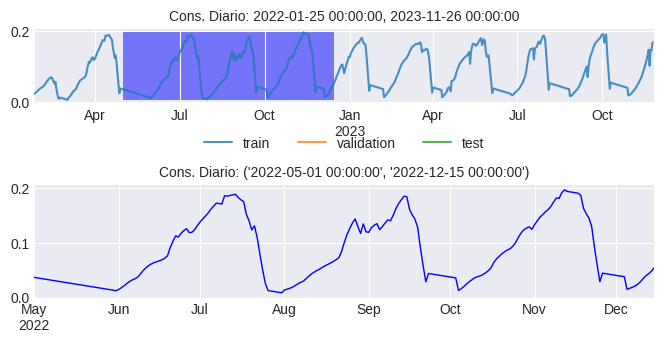

In [ ]:
# Plot time series with zoom
# ==============================================================================
zoom = ('2022-05-01 00:00:00','2022-12-15 00:00:00')

fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['Cons. Diario'].plot(ax=main_ax, label='train', alpha=0.8)
data_val['Cons. Diario'].plot(ax=main_ax, label='validation', alpha=0.8)
data_test['Cons. Diario'].plot(ax=main_ax, label='test', alpha=0.8)
min_y = min(data['Cons. Diario'])
max_y = max(data['Cons. Diario'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
data.loc[zoom[0]: zoom[1]]['Cons. Diario'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Cons. Diario: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Cons. Diario: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

Rellenar las fechas Faltantes

In [ ]:
historico = data.copy()
historico

,Granja,Lote,Acumulado,Cons. Diario,Dia,Suavizado,Suavizado_Exponencial
Fecha,,,,,,,
2022-01-25,GRANJA KM22,2201PPKM22-2,52889.0,0.023814,0.0,0.020545,0.023814
2022-01-26,GRANJA KM22,2201PPKM22-2,52864.0,0.025900,0.0,0.022145,0.025204
2022-01-27,GRANJA KM22,2201PPKM22-2,52837.0,0.028415,0.0,0.024058,0.027345
2022-01-28,GRANJA KM22,2201PPKM22-2,52809.0,0.031016,0.0,0.026225,0.029792
2022-01-29,GRANJA KM22,2201PPKM22-2,52788.0,0.033302,0.0,0.028489,0.032132
...,...,...,...,...,...,...,...
2023-11-22,GRANJA KM22,2305PPKM22-2,40421.0,0.146113,27.0,0.109751,0.136356
2023-11-23,GRANJA KM22,2305PPKM22-2,40405.0,0.145313,28.0,0.114800,0.143394
2023-11-24,GRANJA KM22,2305PPKM22-2,40385.0,0.165957,29.0,0.121339,0.158436


In [ ]:
data = data['Cons. Diario']
data = data.reset_index()
data.columns = ['datetime','y']
data = data.set_index('datetime')
data = data.asfreq('D')
data_train = data.loc[:end_train]
data_test = data.loc[end_train:]
data_train


,y
datetime,
2022-01-25,0.023814
2022-01-26,0.025900
2022-01-27,0.028415
2022-01-28,0.031016
2022-01-29,0.033302
...,...
2023-11-20,0.146913
2023-11-21,0.102602
2023-11-22,0.146113


## **Predicciones**

In [ ]:
days_to_predict = 35
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags = days_to_predict
                 )

In [ ]:

# Create and fit a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
# forecaster = ForecasterAutoreg(
#                  regressor = RandomForestRegressor(random_state=123),
#                  lags      =  35
#              )
forecaster.fit(y=data_train['y'])
forecaster


ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35] 
Transformer for y: None 
Transformer for exog: None 
Window size: 35 
Weight function included: False 
Diffe

In [ ]:

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data_test)+27)
predictions.to_frame()

,pred
2023-11-25,0.171803
2023-11-26,0.174458
2023-11-27,0.168002
2023-11-28,0.169558
2023-11-29,0.172668
2023-11-30,0.176622
2023-12-01,0.181294
2023-12-02,0.184207
2023-12-03,0.187448
2023-12-04,0.187480


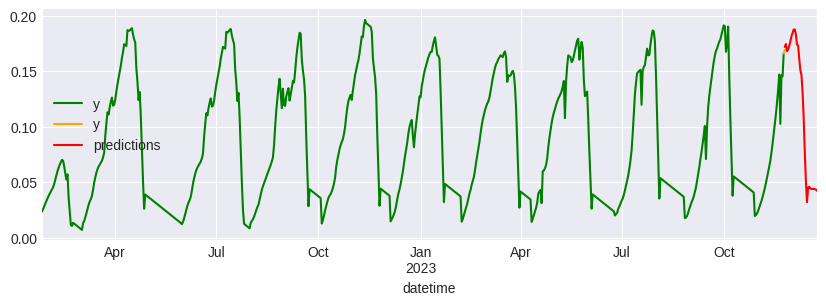

In [ ]:
# **************************************************************************************************************

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
data_train.loc[:end_train].plot(ax=ax, label='train', color = 'green')
data_test.loc[end_train:].plot(ax=ax, label='test', color = 'orange')
predictions.plot(ax=ax, label='predictions', color='red')
ax.legend();

In [ ]:
predictions = predictions.to_frame()

In [ ]:
historico = historico.loc[:end_train].reset_index()


In [ ]:
historico

,Fecha,Granja,Lote,Acumulado,Cons. Diario,Dia,Suavizado,Suavizado_Exponencial
0,2022-01-25,GRANJA KM22,2201PPKM22-2,52889.0,0.023814,0.0,0.020545,0.023814
1,2022-01-26,GRANJA KM22,2201PPKM22-2,52864.0,0.025900,0.0,0.022145,0.025204
2,2022-01-27,GRANJA KM22,2201PPKM22-2,52837.0,0.028415,0.0,0.024058,0.027345
3,2022-01-28,GRANJA KM22,2201PPKM22-2,52809.0,0.031016,0.0,0.026225,0.029792
4,2022-01-29,GRANJA KM22,2201PPKM22-2,52788.0,0.033302,0.0,0.028489,0.032132
...,...,...,...,...,...,...,...,...
664,2023-11-20,GRANJA KM22,2305PPKM22-2,40453.0,0.146913,25.0,0.123027,0.140520
665,2023-11-21,0,0,0.0,0.102602,0.0,0.102602,0.115242
666,2023-11-22,GRANJA KM22,2305PPKM22-2,40421.0,0.146113,27.0,0.109751,0.136356
667,2023-11-23,GRANJA KM22,2305PPKM22-2,40405.0,0.145313,28.0,0.114800,0.143394


In [ ]:
historico = historico[['Fecha','Cons. Diario','Dia','Lote']]


In [ ]:
last_day = historico.iloc[-1]['Dia']
last_lote = historico.iloc[-1]['Lote']
fecha_recepcion = historico[historico.Lote == last_lote]['Fecha'].min()
historico['Dia']=historico['Dia'].fillna(0).astype(int)
print(f"El lote {last_lote} esta en el dia {last_day}")
print("Fecha de recepcion " + str(fecha_recepcion))

El lote 2305PPKM22-2 esta en el dia 29.0
Fecha de recepcion 2023-10-29 00:00:00


<ipython-input-26-a959ae52137c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historico['Dia']=historico['Dia'].fillna(0).astype(int)


Dataframe de prediccion con XGBooster

In [ ]:
prueba = predictions.reset_index()
# Agregar una columna de incrementador como contador de fechas
prueba['Dia'] = range(int(last_day)+1, len(prueba) + int(last_day) +1)
prueba['Lote'] = last_lote
# Calcular la fecha resultante sumando el incrementador como días
prueba.columns = ['Fecha','Cons. Diario','Dia','Lote']
prueba.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Fecha         30 non-null     datetime64[ns]
 1   Cons. Diario  30 non-null     float64       
 2   Dia           30 non-null     int64         
 3   Lote          30 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
df_concat = pd.concat([historico,prueba])
df_concat

,Fecha,Cons. Diario,Dia,Lote
0,2022-01-25,0.023814,0,2201PPKM22-2
1,2022-01-26,0.025900,0,2201PPKM22-2
2,2022-01-27,0.028415,0,2201PPKM22-2
3,2022-01-28,0.031016,0,2201PPKM22-2
4,2022-01-29,0.033302,0,2201PPKM22-2
...,...,...,...,...
25,2023-12-20,0.044107,55,2305PPKM22-2
26,2023-12-21,0.044093,56,2305PPKM22-2
27,2023-12-22,0.043861,57,2305PPKM22-2
28,2023-12-23,0.043505,58,2305PPKM22-2


Estimar consumo cuando sobrepasa el limite de tiempo historico

> Se recorta del dataframe orginal para obtener la regresion lineal




In [ ]:
pred = predictions.reset_index()
max_fecha = pred['index'].min()
min_fecha = max_fecha - timedelta(7)#fecha_recepcion
estimator = data[min_fecha:max_fecha]
estimator = estimator.reset_index()
estimator

,datetime,y
0,2023-11-18,0.121669
1,2023-11-19,0.133260
2,2023-11-20,0.146913
3,2023-11-21,0.102602
4,2023-11-22,0.146113
5,2023-11-23,0.145313
6,2023-11-24,0.165957
7,2023-11-25,0.169062


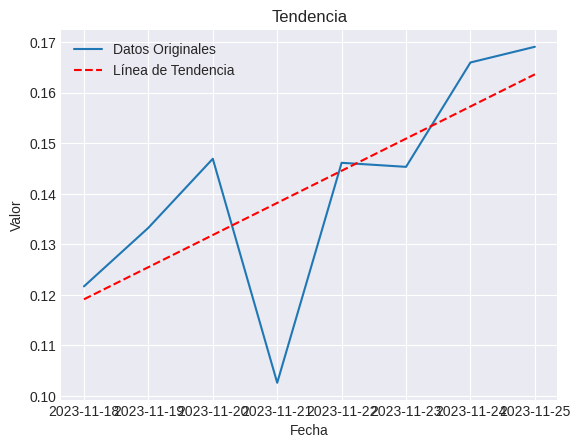

In [ ]:
# Convertir las fechas a números enteros para facilitar el cálculo
estimator['fecha_num'] = pd.to_numeric(estimator['datetime'])

# Calcular la regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(estimator['fecha_num'], estimator['y'])

# Calcular la línea de tendencia
tendencia = intercept + slope * estimator['fecha_num']

# Crear un gráfico
plt.plot(estimator['datetime'], estimator['y'], label='Datos Originales')
plt.plot(estimator['datetime'], tendencia, label='Línea de Tendencia', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Tendencia')
plt.legend()
plt.show()

In [ ]:
df_tendencia = pd.DataFrame({
    'Fecha': estimator['datetime'],
    'tendencia': tendencia
})
df_tendencia

,Fecha,tendencia
0,2023-11-18,0.119113
1,2023-11-19,0.125470
2,2023-11-20,0.131826
3,2023-11-21,0.138183
4,2023-11-22,0.144539
5,2023-11-23,0.150896
6,2023-11-24,0.157252
7,2023-11-25,0.163609


In [ ]:
# Estimar nuevos valores para fechas futuras
nuevas_fechas = pd.date_range(start=df_tendencia['Fecha'].max(), periods=27, freq='D')  # Cambia 'periods' según sea necesario

# Convertir las nuevas fechas a números enteros
nuevas_fechas_num = pd.to_numeric(nuevas_fechas)

# Estimar los nuevos valores basados en la tendencia
nuevos_valores_estimados = intercept + slope * nuevas_fechas_num

# Crear un DataFrame con las nuevas fechas y los valores estimados
df_nuevos_valores = pd.DataFrame({
    'Fecha': nuevas_fechas,
    'valor_estimado': nuevos_valores_estimados
})

# Mostrar el DataFrame con las nuevas fechas y valores estimados
print(df_nuevos_valores)

        Fecha  valor_estimado
0  2023-11-25        0.163609
1  2023-11-26        0.169965
2  2023-11-27        0.176322
3  2023-11-28        0.182679
4  2023-11-29        0.189035
5  2023-11-30        0.195392
6  2023-12-01        0.201748
7  2023-12-02        0.208105
8  2023-12-03        0.214461
9  2023-12-04        0.220818
10 2023-12-05        0.227174
11 2023-12-06        0.233531
12 2023-12-07        0.239887
13 2023-12-08        0.246244
14 2023-12-09        0.252600
15 2023-12-10        0.258957
16 2023-12-11        0.265313
17 2023-12-12        0.271670
18 2023-12-13        0.278026
19 2023-12-14        0.284383
20 2023-12-15        0.290739
21 2023-12-16        0.297096
22 2023-12-17        0.303453
23 2023-12-18        0.309809
24 2023-12-19        0.316166
25 2023-12-20        0.322522
26 2023-12-21        0.328879


# **Prediccion cuando se desborda del limite**

In [ ]:
df_desborde = pd.merge(df_concat,df_nuevos_valores,on='Fecha')
df_desborde

,Fecha,Cons. Diario,Dia,Lote,valor_estimado
0,2023-11-25,0.171803,30,2305PPKM22-2,0.163609
1,2023-11-26,0.174458,31,2305PPKM22-2,0.169965
2,2023-11-27,0.168002,32,2305PPKM22-2,0.176322
3,2023-11-28,0.169558,33,2305PPKM22-2,0.182679
4,2023-11-29,0.172668,34,2305PPKM22-2,0.189035
5,2023-11-30,0.176622,35,2305PPKM22-2,0.195392
6,2023-12-01,0.181294,36,2305PPKM22-2,0.201748
7,2023-12-02,0.184207,37,2305PPKM22-2,0.208105
8,2023-12-03,0.187448,38,2305PPKM22-2,0.214461
9,2023-12-04,0.187480,39,2305PPKM22-2,0.220818


Resultado


In [ ]:
df_resultado = pd.merge(df_concat,df_desborde, on = 'Fecha')
df_resultado.loc[df_resultado['Dia_x']>=45,'Pred'] = df_resultado['valor_estimado']
df_resultado.loc[df_resultado['Pred'].isna(),'Pred'] = df_resultado['Cons. Diario_x']
# df_resultado = df_resultado[['Fecha','Lote_x','Dia_x','Pred']]
df_resultado['AVG'] = (df_resultado['Cons. Diario_x'] + df_resultado['valor_estimado'])/2
df_resultado

,Fecha,Cons. Diario_x,Dia_x,Lote_x,Cons. Diario_y,Dia_y,Lote_y,valor_estimado,Pred,AVG
0,2023-11-25,0.171803,30,2305PPKM22-2,0.171803,30,2305PPKM22-2,0.163609,0.171803,0.167706
1,2023-11-26,0.174458,31,2305PPKM22-2,0.174458,31,2305PPKM22-2,0.169965,0.174458,0.172212
2,2023-11-27,0.168002,32,2305PPKM22-2,0.168002,32,2305PPKM22-2,0.176322,0.168002,0.172162
3,2023-11-28,0.169558,33,2305PPKM22-2,0.169558,33,2305PPKM22-2,0.182679,0.169558,0.176118
4,2023-11-29,0.172668,34,2305PPKM22-2,0.172668,34,2305PPKM22-2,0.189035,0.172668,0.180851
5,2023-11-30,0.176622,35,2305PPKM22-2,0.176622,35,2305PPKM22-2,0.195392,0.176622,0.186007
6,2023-12-01,0.181294,36,2305PPKM22-2,0.181294,36,2305PPKM22-2,0.201748,0.181294,0.191521
7,2023-12-02,0.184207,37,2305PPKM22-2,0.184207,37,2305PPKM22-2,0.208105,0.184207,0.196156
8,2023-12-03,0.187448,38,2305PPKM22-2,0.187448,38,2305PPKM22-2,0.214461,0.187448,0.200955
9,2023-12-04,0.187480,39,2305PPKM22-2,0.187480,39,2305PPKM22-2,0.220818,0.187480,0.204149
